In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# np.random.seed(0)

In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
cur.execute('''SELECT *
                FROM OrderDetail;''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [4]:
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [5]:
no_discount = df.loc[df['Discount'] == 0]
discount = df.loc[df['Discount']!= 0]
discount.info()
print('**************************')
no_discount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 6 to 2152
Data columns (total 6 columns):
Id           838 non-null object
OrderId      838 non-null int64
ProductId    838 non-null int64
UnitPrice    838 non-null float64
Quantity     838 non-null int64
Discount     838 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 45.8+ KB
**************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 2154
Data columns (total 6 columns):
Id           1317 non-null object
OrderId      1317 non-null int64
ProductId    1317 non-null int64
UnitPrice    1317 non-null float64
Quantity     1317 non-null int64
Discount     1317 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 72.0+ KB


In [6]:
def get_sample(data, n):
    return list(data.sample(n, replace = False))
    pass
def get_sample_mean(sample):
    return np.mean(sample)
    pass
def create_sample_distribution(data, dist_size=100, n=30):
    sample_means = []
    for i in range(dist_size):
        to_mean = get_sample(data, n)
        sample_means.append(get_sample_mean(to_mean))
    return sample_means
    pass

In [7]:
qty_no_discount = no_discount['Quantity']
qty_discount = discount['Quantity']

Text(0, 0.5, 'Quantity Probability')

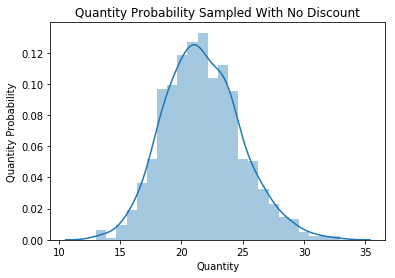

In [8]:
#creation of a sample set for quantity without discounts (grqaph for visualization)
no_discount_sample = create_sample_distribution(qty_no_discount,dist_size=1000,n=30)
sns.distplot(no_discount_sample)
plt.title('Quantity Probability Sampled With No Discount')
plt.xlabel('Quantity')
plt.ylabel('Quantity Probability')

Text(0, 0.5, 'Quantity Probability')

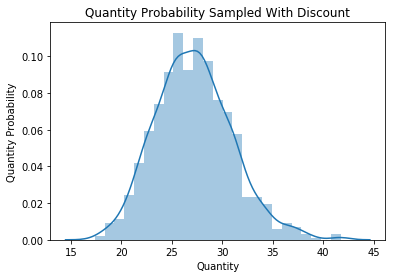

In [9]:
#creation of a sample set for quantity with discounts (grqaph for visualization)
with_discount_sample = create_sample_distribution(qty_discount,dist_size=1000,n=30)
sns.distplot(with_discount_sample)
plt.title('Quantity Probability Sampled With Discount')
plt.xlabel('Quantity')
plt.ylabel('Quantity Probability')

Create sample for z test from the normally distributed samples (now the population total)

In [10]:
#Statistics for the discount quantity sample
disc_total_pop = with_discount_sample
disc_samp = np.random.choice(disc_total_pop, size=400, replace = False)

x_bar_d = np.mean(disc_total_pop)
mu_d = np.mean(disc_samp)
sigma_d = np.std(disc_samp)
n_d = 400 #sample size


#Statistics for the no discount quantity sample
no_disc_total_pop = no_discount_sample
no_disc_samp = np.random.choice(no_disc_total_pop, size=400, replace=False)


x_bar_nd = np.mean(no_disc_total_pop)
mu_nd = np.mean(no_disc_samp)
sigma_nd = np.std(no_disc_samp)
n_nd = 400 #sample size


#z test formula for comparing two means:
z_num = (x_bar_nd-x_bar_d)-(mu_nd-mu_d)
z_den = np.sqrt(((sigma_nd)**2/(n_nd))+((sigma_d)**2/(n_d)))

z = z_num/z_den
z_cdf = stats.norm.cdf(z)
print('z-value',z)
print('z-value area',z_cdf)
print('p-value', 2*(1-z_cdf)) #two-tailed p-value

z-value 0.005870349195381225
z-value area 0.5023419170439499
p-value 0.9953161659121001


Summary:
The total population is the population of all quantities

Hypothesis test:

H_0 : mu_1 = mu_2
H1 : mu_1 != mu_2

where mu_1 represents the mean of the no discount data and mu_2 represents the data with a discount

Because the p-value is always greater than any alpha we may have chosen (.1/2, .5/2, or .01/2) the null hyphothesis is rejected. 

This means there is evidence to support the idea that the means for non-discount population and discount populations (w.r.t. quantity) are not equal; another step this can be taken is to say discount may have an effect on quantity ordered. 

In [11]:
t_stat, p_val = stats.ttest_rel(disc_total_pop,no_disc_total_pop)

print('t_stat',t_stat)
print('p_val',p_val)

t_stat 35.9144518361917
p_val 4.792478492197406e-182


In [12]:
'''#NEED TO FIX ALL OF THIS NOT SET UP FOR TWO TAILS AND RANGES ARE INCORRECT
alpha = (1-.01)/2

plt.style.use('seaborn')
plt.fill_between(x=np.arange(-4,z_cdf,0.01),
                 y1= stats.norm.pdf(np.arange(-4,z_cdf,0.01)) ,
                 facecolor='red',
                 alpha=0.35,
                 label= 'Area below z-statistic'
                 )

plt.fill_between(x=np.arange(z_cdf,4,0.01), 
                 y1= stats.norm.pdf(np.arange(z_cdf,4,0.01)) ,
                 facecolor='blue',
                 alpha=0.35, 
                 label= 'Area above z-statistic')
plt.legend()
plt.title ('z-statistic = '+str(z_cdf));

plt.axvline(alpha,color='red', linestyle='--', lw=5,label='Critical Values')
plt.axvline(-alpha,color='red', linestyle='--', lw=5)
plt.legend()'''


"#NEED TO FIX ALL OF THIS NOT SET UP FOR TWO TAILS AND RANGES ARE INCORRECT\nalpha = (1-.01)/2\n\nplt.style.use('seaborn')\nplt.fill_between(x=np.arange(-4,z_cdf,0.01),\n                 y1= stats.norm.pdf(np.arange(-4,z_cdf,0.01)) ,\n                 facecolor='red',\n                 alpha=0.35,\n                 label= 'Area below z-statistic'\n                 )\n\nplt.fill_between(x=np.arange(z_cdf,4,0.01), \n                 y1= stats.norm.pdf(np.arange(z_cdf,4,0.01)) ,\n                 facecolor='blue',\n                 alpha=0.35, \n                 label= 'Area above z-statistic')\nplt.legend()\nplt.title ('z-statistic = '+str(z_cdf));\n\nplt.axvline(alpha,color='red', linestyle='--', lw=5,label='Critical Values')\nplt.axvline(-alpha,color='red', linestyle='--', lw=5)\nplt.legend()"